# 机器翻译实验

<hr>

### 1. 安装依赖

In [29]:
! pip install jieba

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. 导入依赖库

In [30]:
import re
import os
import io
import time
import jieba
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

### 3. 数据准备

#### 3.1 定义数据路径

In [31]:
path_to_file = "data/cmn.txt"        ## 数据集文件

#### 3.2 定义预处理函数

In [32]:
def preprocess_eng(text):
    text = text.lower().strip()

    # 单词和标点之间加空格
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    text = re.sub(r"([?.!,])", r" \1 ",text)
    # 多个空格合并为一个
    text = re.sub(r'[" "]+', " ", text)

    # 除了(a-z, A-Z, ".", "?", "!", ",")这些字符外，全替换成空格
    text = re.sub(r"[^a-zA-Z?.!,]+", " ", text)
    text = text.rstrip().strip()

    # 增加开始结束标志，让模型知道何时停止预测
    text = '<start> ' + text + ' <end>'
    return text

def preprocess_chn(text):
    text = text.lower().strip()
    text = jieba.cut(text, cut_all=False, HMM=True)
    text = " ".join(list(text))  # 词之间增加空格
    text = '<start> ' + text + ' <end>'
    return text

In [33]:
en_sentence = "May I borrow this book?"
chn_sentence = "我可以借这本书吗？"
print(preprocess_eng(en_sentence))
print(preprocess_chn(chn_sentence))

<start> may i borrow this book ? <end>
<start> 我 可以 借 这 本书 吗 ？ <end>


#### 3.3 提取双语数据

In [34]:
en_texts, cn_texts = [], []
for line in open(path_to_file, encoding='UTF-8').read().strip().split('\n'):
    en_text, cn_text = line.split('\t')
    en_text_prep, cn_text_prep = preprocess_eng(en_text), preprocess_chn(cn_text)
    en_texts.append(en_text_prep)
    cn_texts.append(cn_text_prep)

In [35]:
print(en_texts[-1])
print(cn_texts[-1])
print(len(en_texts), len(cn_texts))

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如果 一個 人 在 成人 前 沒 有 機會習 得 目標 語言 ， 他 對 該 語言 的 認識 達 到 母語者 程度 的 機會 是 相當 小 的 。 <end>
20403 20403


#### 3.4 文字ID映射

In [36]:
en_converter = tf.keras.preprocessing.text.Tokenizer(filters='')
en_converter.fit_on_texts(en_texts)
cn_converter = tf.keras.preprocessing.text.Tokenizer(filters='')
cn_converter.fit_on_texts(cn_texts)

en_text_ids = en_converter.texts_to_sequences(en_texts)
cn_text_ids = cn_converter.texts_to_sequences(cn_texts)

In [37]:
print(en_texts[0])
print(en_text_ids[0])

print(cn_texts[0])
print(cn_text_ids[0])

<start> hi . <end>
[1, 1727, 3, 2]
<start> 嗨 。 <end>
[1, 2036, 3, 2]


#### 3.5 Padding填充

In [38]:
max_en_len = max([len(seq) for seq in en_text_ids])
max_cn_len = max([len(seq) for seq in cn_text_ids])
print("英文最大长度：{}".format(max_en_len))
print("中文最大长度：{}".format(max_cn_len))

en_text_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(en_text_ids, maxlen=max_en_len, padding='post')
cn_text_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(cn_text_ids, maxlen=max_cn_len, padding='post')

print(en_texts[0])
print(en_text_ids_padded[0])

print(cn_texts[0])
print(cn_text_ids_padded[0])

英文最大长度：38
中文最大长度：32
<start> hi . <end>
[   1 1727    3    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
<start> 嗨 。 <end>
[   1 2036    3    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


#### 3.5 分割训练、验证

In [39]:
# 中文为源语言，英文为目标语言
# 分割训练数据和验证数据
input_cn_train, input_cn_val, target_en_train, target_en_val = train_test_split(
    cn_text_ids_padded, en_text_ids_padded, test_size=0.05)

# 显示训练数据和验证数据的大小
print(len(input_cn_train), len(target_en_train),
      len(input_cn_val), len(target_en_val))

19382 19382 1021 1021


#### 3.6 转换成tf.data.Dataset

In [40]:
# 先做shuffle， 再取batch
batch_size=64
train_dataset = tf.data.Dataset.from_tensor_slices((input_cn_train, target_en_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((input_cn_val, target_en_val))
valid_dataset = valid_dataset.batch(batch_size=batch_size, drop_remainder=True)

In [41]:
next(iter(valid_dataset))

(<tf.Tensor: shape=(64, 32), dtype=int32, numpy=
 array([[   1, 6119,  147, ...,    0,    0,    0],
        [   1,   63,    7, ...,    0,    0,    0],
        [   1, 3172,  392, ...,    0,    0,    0],
        ...,
        [   1,   14, 1927, ...,    0,    0,    0],
        [   1,   14,   15, ...,    0,    0,    0],
        [   1,   12, 3261, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 38), dtype=int32, numpy=
 array([[   1,    5,  480, ...,    0,    0,    0],
        [   1,   77,    7, ...,    0,    0,    0],
        [   1,    5, 2034, ...,    0,    0,    0],
        ...,
        [   1,   13,   51, ...,    0,    0,    0],
        [   1,   13,  111, ...,    0,    0,    0],
        [   1,   18, 1820, ...,    0,    0,    0]])>)

### 4. 模型训练

#### 4.1 配置参数

In [42]:
embedding_dim = 256
hidden_units = 1024
# 0 是为padding保留的一个特殊id， 所以要 + 1
cn_vocab_size = len(cn_converter.word_index) + 1
en_vocab_size = len(en_converter.word_index) + 1

#### 4.2 定义Encoder

In [43]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        # vacab_size=vocab_inp_size=9394, embedding_dim=256 enc_units=1024 batch_sz=64
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       #recurrent_activation='sigmoid',
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        # x 是训练数据，shape == (batch_size，max_length)  -> (64, 46)
        
        # embedding 后得到每个词的词向量, x shape == (batch_size, max_length, embedding_dim) -> (64, 46, 256)
        x = self.embedding(x)
        
        # 在GRU中，每一个时间步，输出层和隐藏层是相等的
        # output 是所有时间步的输出层输出 shape == (batch_size, max_length, units) -> (64, 46, 1024)
        # state 是最后一个时间步的隐藏层输出, shape == (batch_size, units) -> (64, 1024)
        output, state = self.gru(x, initial_state=hidden)

        return output, state

    def initialize_hidden_state(self):
        # 初始化gru的隐层参数,  shape == (batch_size, units) -> (64,1024)
        return tf.zeros((self.batch_sz, self.enc_units))

#### 4.2 定义Attention

In [44]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape == (batch_size, hidden size)
        # 扩展时间维度 shape == (batch_size, 1, hidden size)
        # 为了计算后面的 score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # score 维度为1是因为应用了self.V, V的维度是1
        # 应用self.V前后的维度是 (batch_size, max_length, units) --> (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # 使用softmax得到attention的权重， attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape == (batch_size, max_length, hidden_size)
        context_vector = attention_weights * values
        # 相加后的attention 上下文向量的维度：shape context_vector == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

#### 4.3 定义Decoder

In [45]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        # vocab_size=vocab_tar_size=6082, embedding_dim=256, dec_units=1024, batch_sz=64
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # 输出的维度是目标语言词汇表的大小，返回的是softmax概率，词汇表中每一个词的概率
        self.fc = tf.keras.layers.Dense(vocab_size)

        # attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

        # 计算decoder的第一个隐状态和encoder所有输入之间的attention 权重， 得到上下文向量, context_vector
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # embedding后的维度 == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 把上下文向量context_vector 和 输入embedding拼接在一起
        # context_vector shape == (batch_size, units) -> (64, 1024)
        # 拼接后的数据维度 == (batch_size, 1, embedding_dim + hidden_size) -> (64, 1, 1024 + 256)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 把拼接后的向量输入gru
        # 得到当前时间步的输出和隐状态
        # output shape == (batch_size, 1, units) -> (64, 1, 1024), state shape == (batch_size, units) -> (64,1024)
        output, state = self.gru(x)

        # output shape == (batch_size, hidden_size=1024)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab) -> (64, 6082)
        x = self.fc(output)

        return x, state, attention_weights

In [46]:
encoder = Encoder(cn_vocab_size, embedding_dim, hidden_units, batch_size)
decoder = Decoder(en_vocab_size, embedding_dim, hidden_units, batch_size)

#### 4.4 定义优化器和损失

In [47]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """Calculate the loss value

    Args:
        real: the true label  shape == (batch_size,) -> (64,)
        pred: the probability of each word from the vocabulary, is the output from the decoder 
                 shape == (batch_size, vocab_size) -> (64, 6082)

    Returns: 
        the average loss of the data in a batch size
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### 4.5 定义checkpoint

In [48]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = checkpoint_dir +  '/seq2seq_mt_ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
fine_tune = True
pretrain_ckpt = "pre_model/pretrain_ckpt"
if fine_tune:
    checkpoint.restore(pretrain_ckpt)

#### 4.6 定义训练函数

In [57]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        # decoder的第一个输入为 '<start>'
        # dec input shape == (batch_size, 1) -> (64, 1)
        dec_input = tf.expand_dims(
            [en_converter.word_index['<start>']] * batch_size, 1)
        # 将当前输出作为下一步的输入
        # 第一个输入为 <start>, 所有 t 从 1 开始 (不是 0)
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(
                dec_input, dec_hidden, enc_output)

            # 计算当前timestep的损失
            loss += loss_function(targ[:, t], predictions)

            # 更新输入为上一时刻的输出
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    # 聚合所有参数
    variables = encoder.trainable_variables + decoder.trainable_variables

    # 计算梯度
    gradients = tape.gradient(loss, variables)

    # 根据梯度更新变量
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

#### 4.7 启动训练

In [61]:
EPOCHS = 3  # 50 测试需要，设置训练轮数为3， 实际为保证效果，建议设置为50

for epoch in range(EPOCHS):
    start = time.time()

    # 获取gru的初始状态
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(iter(train_dataset)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    # 每两个迭代保存一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

AttributeError: in user code:

    File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_32616\2729203214.py", line 6, in train_step  *
        enc_output, enc_hidden = encoder(inp, enc_hidden)
    File "d:\anaconda\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\lenovo\AppData\Local\Temp\__autograph_generated_filel3kbo1_3.py", line 11, in tf__call
        (output, state) = ag__.converted_call(ag__.ld(self).gru, (ag__.ld(x),), dict(initial_state=ag__.ld(hidden)), fscope)

    AttributeError: Exception encountered when calling layer 'encoder_1' (type Encoder).
    
    in user code:
    
        File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_32616\4060373263.py", line 23, in call  *
            output, state = self.gru(x, initial_state=hidden)
        File "d:\anaconda\lib\site-packages\keras\src\layers\rnn\base_rnn.py", line 626, in __call__  **
            return super().__call__(inputs, **kwargs)
        File "d:\anaconda\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
            raise e.with_traceback(filtered_tb) from None
        File "d:\anaconda\lib\site-packages\keras\src\layers\rnn\gru.py", line 851, in _defun_gru_call
            "kernel": gru_lstm_utils.read_variable_value(self.cell.kernel),
    
        AttributeError: Exception encountered when calling layer 'gru_2' (type GRU).
        
        'GRUCell' object has no attribute 'kernel'
        
        Call arguments received by layer 'gru_2' (type GRU):
          • inputs=tf.Tensor(shape=(64, 32, 256), dtype=float32)
          • mask=None
          • training=None
          • initial_state=['tf.Tensor(shape=(64, 1024), dtype=float32)']
    
    
    Call arguments received by layer 'encoder_1' (type Encoder):
      • x=tf.Tensor(shape=(64, 32), dtype=int32)
      • hidden=tf.Tensor(shape=(64, 1024), dtype=float32)


### 5. 推理测试

#### 5.1 定义推理函数

In [ ]:
def inference(sentence):
    """Translate a sentence

    Args:
        sentence: the test sentence        
    """

    attention_plot = np.zeros((max_en_len, max_cn_len))

    sentence = preprocess_chn(sentence)

    # 词转ID
    inputs = [cn_converter.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_cn_len, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # hidden shape == (1, 1024)
    hidden = [tf.zeros((1, hidden_units))]
    # enc out shape == (1, max_length_inp, 1024) -> (1, 46, 1024)
    # enc hidden shape == (1, 1024)
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([en_converter.word_index['<start>']], 0)

    for t in range(max_en_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
#         print(attention_weights)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += en_converter.index_word[predicted_id] + ' '

        # 预测到 '<end>' 时停止
        if en_converter.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 当前输出作为下一次输入
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

#### 5.2 定义attention可视化函数

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    # cmap means color map, viridis means blue-green-yellow
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    # ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=font)
    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    # ax.set_yticklabels([''] + predicted_sentence, fontproperties=font, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

#### 5.3 定义翻译测试函数

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = inference(sentence)

    print('输入: %s' % (sentence))
    print('翻译结果: {}'.format(result))

    attention_plot = attention_plot[:len(
        result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

#### 5.4 离线加载预测

In [ ]:
checkpoint_dir = 'checkpoint'
print(tf.train.latest_checkpoint(checkpoint_dir))
# 从最后一次checkpoint中恢复
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint/seq2seq_mt_ckpt-26


输入: <start> 我 有 一只 猫 <end>
翻译结果: i have a cat . <end> 


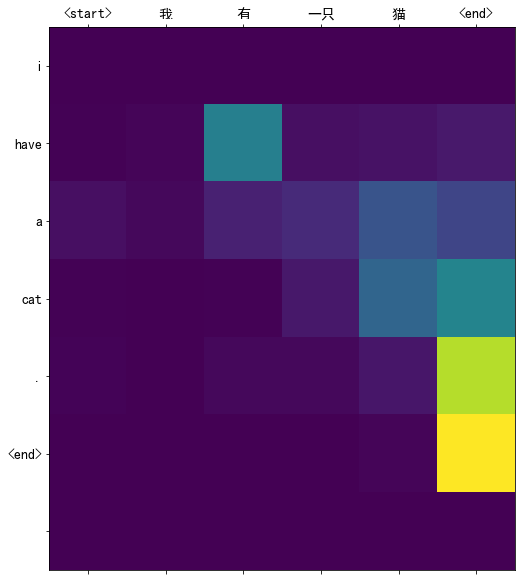

In [ ]:
translate('我有一只猫')